# **ReAct RAG**
A **ReAct** system is an advanced technique that combines reasoning, acting, and retrieving information to solve problems. It works by analyzing its environment, retrieving relevant data, and using it to make decisions or generate responses.

In this example, we will build a ReAct RAG system that uses three vectorstores to manage and retrieve relevant data efficiently:

- **Appointment:** This vectorstore will handle scheduling and details about upcoming appointments.
- **Patient History:** This vectorstore will store and retrieve comprehensive medical histories of patients.
- **Last Appointment Summary:** This vectorstore will provide summaries of the most recent appointments for quick reference.

This system will combine reasoning and data retrieval to provide accurate, context-aware responses, making it useful for managing patient care and appointments.

## **Initial Setup**

In [ ]:
# Initial Setup
!pip install -q athina duckduckgo-search langgraph faiss-gpu pypdf athina-client

In [61]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['ATHINA_API_KEY'] = userdata.get('ATHINA_API_KEY')

In [3]:
# load embedding model
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

## **Appoinment Database**

In [4]:
# load data
from langchain.document_loaders import CSVLoader
loader1 = CSVLoader("/content/appoinment.csv")
documents1 = loader1.load()

In [5]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_overlap=0)
documents1 = text_splitter.split_documents(documents1)

In [6]:
# create vectorstore
from langchain.vectorstores import FAISS
vectorstore1 = FAISS.from_documents(documents1, embeddings)

## **Patient History Database**

In [7]:
# load data
from langchain.document_loaders import CSVLoader
loader2 = CSVLoader("/content/history.csv")
documents2 = loader2.load()

In [33]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter()
documents2 = text_splitter.split_documents(documents2)

In [34]:
# create vectorstore
from langchain.vectorstores import FAISS
vectorstore2 = FAISS.from_documents(documents2, embeddings)

## **Appointment Summary Database**

In [10]:
# load pdf
from langchain_community.document_loaders import PyPDFLoader
loader3 = PyPDFLoader("/content/summary.pdf")
documents3 = loader3.load()

In [11]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
documents3 = text_splitter.split_documents(documents3)

In [12]:
# create vectorstore
from langchain.vectorstores import FAISS
vectorstore3 = FAISS.from_documents(documents3, embeddings)

## **Building ReAct**

In [13]:
# define llm
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [14]:
# create a retrieval chain
from langchain.chains import RetrievalQA
appoinment_retriever = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=vectorstore1.as_retriever())
history_retriever = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=vectorstore2.as_retriever())
pdf_retriever = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=vectorstore3.as_retriever())

In [15]:
# create tools
from langchain.agents import Tool

tools = [
    Tool(
        name="AppoinmentData",
        func=appoinment_retriever.run,
        description="Use this to search the vector store for information."
    ),
    Tool(
        name="PatientHistory",
        func=history_retriever.run,
        description="Use this to perform a vector store for information."
    ),
        Tool(
        name="Summary",
        func=pdf_retriever.run,
        description="Use this to perform a vector store for information."
    ),
]

In [16]:
# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

In [17]:
# add system message
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(
    content=(
        "You are a helpful assistant for doctors. Write a detail patient summary for upcoming appointment: based on a patient ID, patient appointment, "
        "history, and last appointment summary."
    )
)

In [18]:
# Node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [19]:
# build graph
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

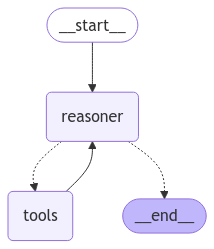

In [66]:
# flow graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Test the System
messages = [HumanMessage(content="patient ID: PT9698")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
# Display the Results
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

patient ID: PT9698
================================== Ai Message ==================================
Tool Calls:
  AppoinmentData (call_1WrXqscYjoTlhXv1lJndIv2s)
 Call ID: call_1WrXqscYjoTlhXv1lJndIv2s
  Args:
    __arg1: PT9698
  PatientHistory (call_wtBaWunYhfKc7JHISQWKeWbZ)
 Call ID: call_wtBaWunYhfKc7JHISQWKeWbZ
  Args:
    __arg1: PT9698
  Summary (call_Qqe5D0OaThjPyEmU2k2mhCUS)
 Call ID: call_Qqe5D0OaThjPyEmU2k2mhCUS
  Args:
    __arg1: PT9698
================================= Tool Message =================================
Name: AppoinmentData

Patient ID: PT9698  
Patient Name: James Taylor  
Reason for Visit: Dental Cleaning  
Patient Symptoms: Mild plaque build-up.
================================= Tool Message =================================
Name: PatientHistory

Patient_ID: PT9698  
Patient_Name: James Taylor  
Patient_Age: 40  
Patient_Gender: Male  
Patient_Emotional_State: James is indiffer

In [47]:
# Extract the relevant data
import pandas as pd

messages_data = []
for message in messages['messages']:
    message_content = message.content if hasattr(message, 'content') else ""
    message_name = message.name if hasattr(message, 'name') else "AI" if "AIMessage" in str(type(message)) else "Human"

    messages_data.append({
        "Message Name": message_name,
        "Content": message_content,
    })

messages_df = pd.DataFrame(messages_data)

In [60]:
# filter and transpose
filtered_df = messages_df.loc[messages_df['Message Name'].isin(['AppoinmentData', 'PatientHistory', 'Summary'])]
filtered_df = filtered_df.reset_index(drop=True)

transposed_df = filtered_df[['Message Name', 'Content']].T
transposed_df.columns = transposed_df.iloc[0]
transposed_df = transposed_df.drop(transposed_df.index[0])

transposed_df

Message Name,AppoinmentData,PatientHistory,Summary
Content,James Taylor is a patient with ID PT9698. The ...,James Taylor is a 40-year-old male with good o...,"Based on the provided context, James Taylor is..."


In [62]:
# converting into dictionary
data = transposed_df.to_dict(orient="records")
data

[{'AppoinmentData': 'James Taylor is a patient with ID PT9698. The reason for his visit is dental cleaning, and he has mild plaque build-up.',
  'PatientHistory': 'James Taylor is a 40-year-old male with good oral hygiene habits, though he sometimes skips flossing. He has had gum therapy in the past but has no current issues. Emotionally, he is indifferent about dental cleaning, viewing it as necessary but not something he looks forward to.',
  'Summary': "Based on the provided context, James Taylor is a patient who had a dental cleaning appointment on October 20, 2024. During the procedure, he remained indifferent but cooperative and acknowledged the importance of regular cleaning and maintaining oral hygiene. The findings indicated mild plaque buildup, no active gum disease, and overall good oral hygiene. Procedures performed included professional dental cleaning and polishing, and flossing techniques were reviewed. Recommendations were given for maintaining oral hygiene, including d

# **Connecting to Athina IDE**

Here we are connecting data to [Athina IDE](https://app.athina.ai/develop) to evaluate the performance of our ReAct pipeline.

In [64]:
# adding to Athina
rows = data

In the Datasets section on [Athina IDE](https://app.athina.ai/develop), you will find the **Create Dataset** option in the top right corner. Click on it and select **Login via API or SDK** to get the `dataset_id` and `Athina API key`.

In [65]:
#connect to Athina
from athina_client.datasets import Dataset
from athina_client.keys import AthinaApiKey

AthinaApiKey.set_key(os.environ['ATHINA_API_KEY'])

try:
    Dataset.add_rows(
        dataset_id='dd4d002b-da81-4efd-8950-ee5e5ffef25d',
        rows=rows
    )
except Exception as e:
    print(f"Failed to add rows: {e}")

After connecting the data using the Athina SDK, you can access your data at https://app.athina.ai/develop/ {{your_data_id}}

This will look something like Image-1. Also, you can run various evaluations to test the performance of our ReAct pipeline in the "Evaluate" section located in the top right corner. Out for Evaluation will look something like Image-2

### **Image 1**

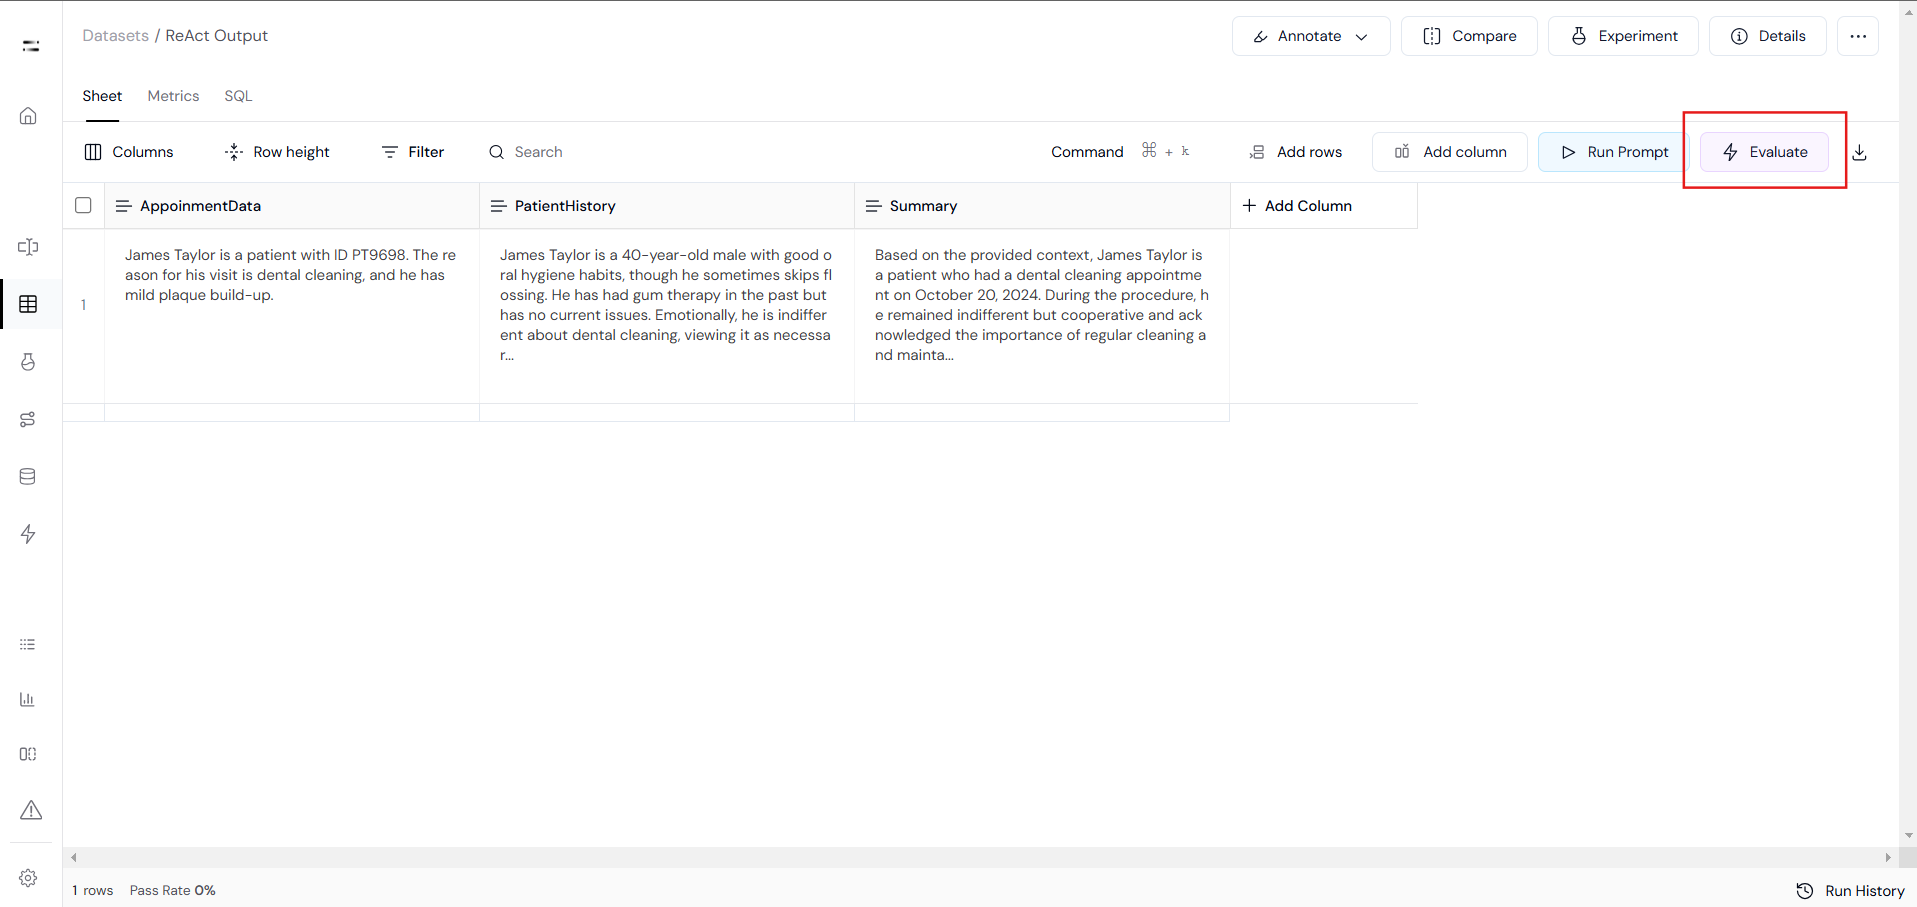

### **Image 2**

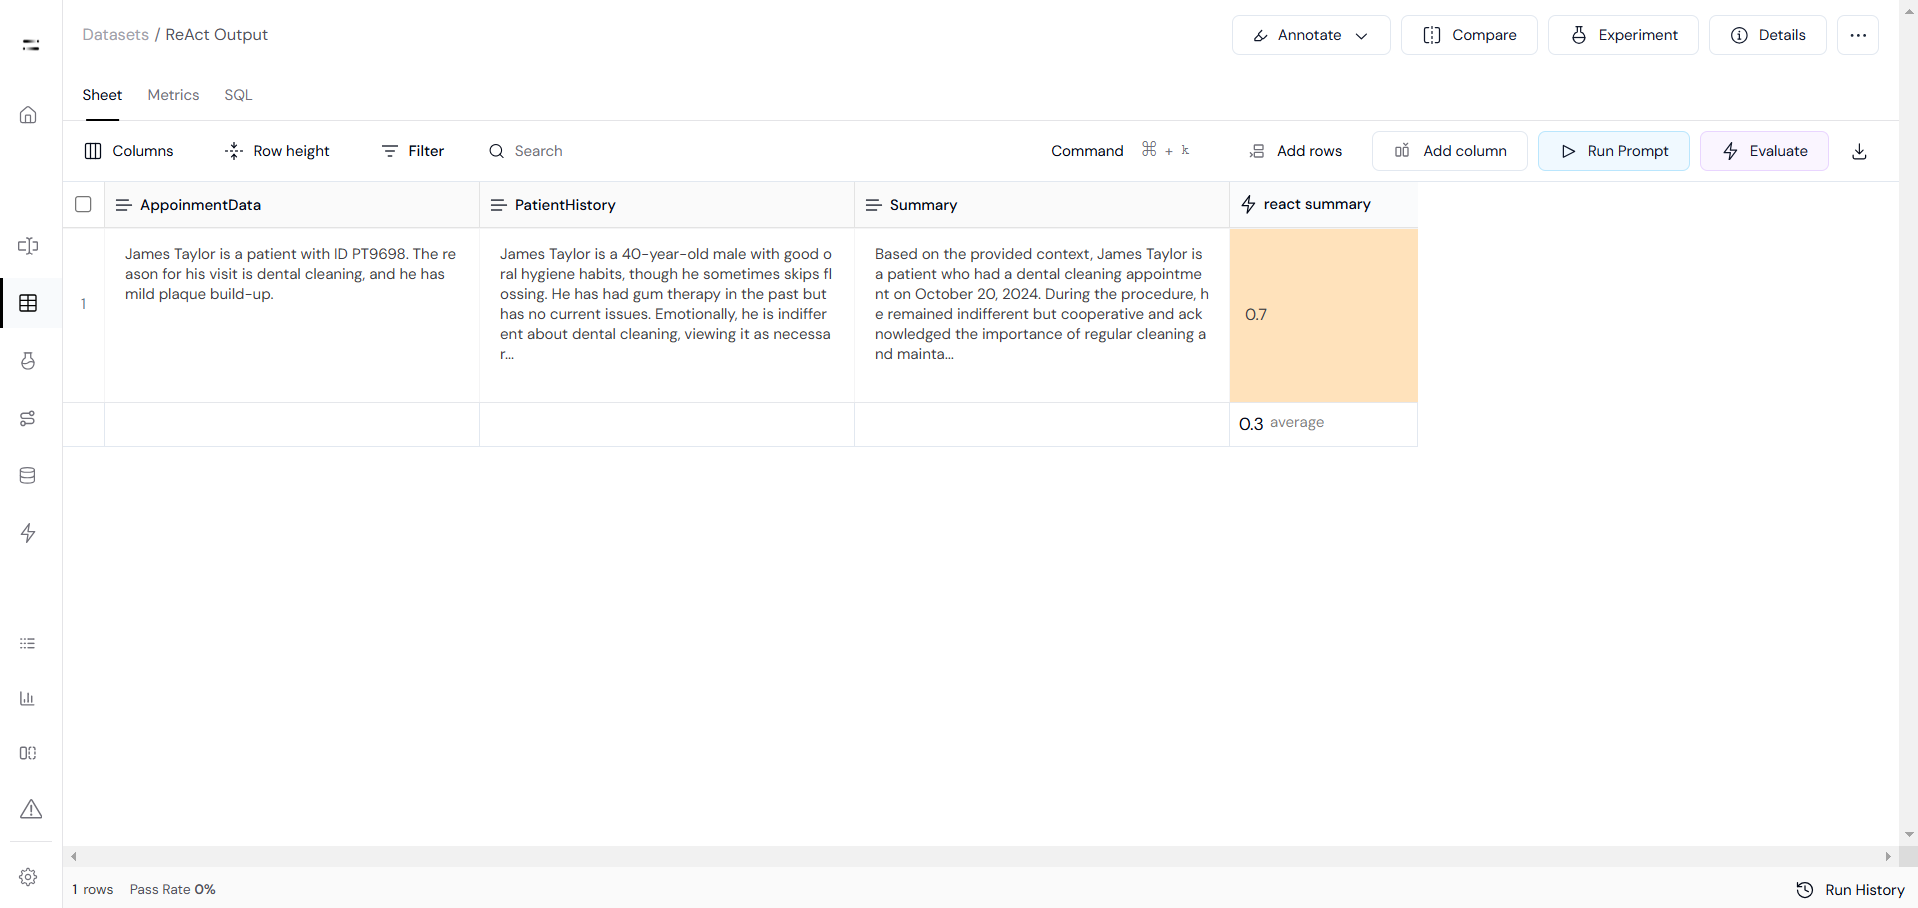